In [1]:
import pickle
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import os
import logging
import tensorflow as tf
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


2024-10-08 00:06:43.977276: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-08 00:06:44.002616: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-08 00:06:44.398214: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Data Loading

In [2]:
def load_data(file_path):
    with open(file_path, 'rb') as file:
        dataset = pickle.load(file)
    return dataset['data'], dataset['labels']

data_path = 'EMNIST_Byclass_Small/'
X_train, y_train = load_data(data_path+'emnist_train.pkl')
X_test, y_test = load_data(data_path+'emnist_test.pkl')

print(X_train[0])



[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  18  36  18   5   0   3  21  37  37  37  37  21
    3   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   3 106 208 111  41  34  84 170 215 217 217 215 170
   79  34   3   0   0   0   0   0   0   0]
 [  0   0   0   0   0   2  77 217 192 159 204 233 251 254 254 252 250 249
  220 174  67   3   0   0   0   0   0   0]
 [  0   0   0   0   0   0  11 142 248 251 254 253 234 217 215 172 130 173
  233 244 174  34   0   0   0   0   0   0]
 [  0   0   0   0   0   0  10 142 250 254 254 248 179 129 125  82  41  84
  187 233 220  79   3   0   0   0   0   0]
 [  0   0   0   0   0   0  46 208 254 254 254 233  84   7   4   2   0   4
   84 173 249 170  21   2   0   0   0   0]
 [  0   0   0   0   1  10 128 246 254 255 254 218  48   0   0   

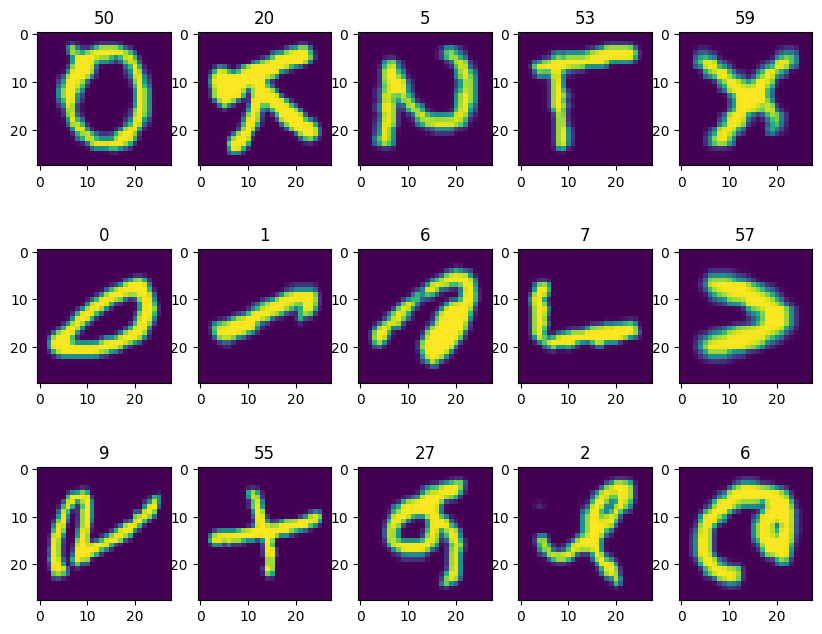

In [3]:
fig,axes = plt.subplots(3,5,figsize=(10,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape([28,28]))
    ax.set_title(y_train[i])

In [4]:
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

num_classes = 62 
train_labels = to_categorical(y_train, num_classes)
test_labels = to_categorical(y_test, num_classes)

print(f"Training data shape: {X_train.shape}, Training labels shape: {train_labels.shape}")
print(f"Test data shape: {y_test.shape}, Test labels shape: {test_labels.shape}")

Training data shape: (100000, 28, 28, 1), Training labels shape: (100000, 62)
Test data shape: (20000,), Test labels shape: (20000, 62)


In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Data augmentation for the training data
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)
#reset agumentation
train_datagen = ImageDataGenerator()
# No augmentation for the validation data, just rescaling
val_datagen = ImageDataGenerator()

# Use .flow() to generate batches of augmented data


In [6]:
epochs = 50
batch_size = 32
loss="sparse_categorical_crossentropy"
#loss="categorical_crossentropy"
input_shape = (28, 28, 1)
num_classes = 62
hyperparameters = {
    'hidden_size' : 128,
    'dropout_rate' : 0.2,
    'learning_rate' : 1e-3,
    'regularization_rate' : 0.01,
    'activation' : 'relu',
    'output_activation' : 'softmax'
}

In [7]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [8]:
def se_block(inputs, reduction_ratio=16):
    filters = inputs.shape[-1]
    se = layers.GlobalAveragePooling2D()(inputs)
    se = layers.Dense(filters // reduction_ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape([1, 1, filters])(se)
    return layers.Multiply()([inputs, se])

def residual_block(inputs, filters, kernel_size=4, stride=1, dropout_rate=0.3, activation='relu', use_se=True):
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Add attention (Squeeze-and-Excitation block) if specified
    if use_se:
        x = se_block(x)

    # Adjust inputs if necessary (to match dimensions)
    if stride != 1 or inputs.shape[-1] != filters:
        inputs = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(inputs)
        inputs = layers.BatchNormalization()(inputs)

    x = layers.Dropout(dropout_rate)(x) 

    # Residual connection
    x = layers.Add()([x, inputs])
    x = layers.Activation(activation)(x)

    return x

def build_resnet(input_shape, num_classes, hyperparameters):
    inputs = layers.Input(shape=input_shape)
    dropout_rate = hyperparameters['dropout_rate']
    hidden_size = hyperparameters['hidden_size']
    activation= hyperparameters['activation']
    regularization_rate = hyperparameters['regularization_rate']
    # Initial convolution layer
    x = layers.Conv2D(hidden_size, (7, 7), padding='same', strides=1)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    # Residual blocks
    x = residual_block(x, hidden_size, dropout_rate=dropout_rate, activation=activation)
    x = residual_block(x, hidden_size*2, stride=2, dropout_rate=dropout_rate, activation=activation)
    x = residual_block(x, hidden_size*4, stride=2, dropout_rate=dropout_rate, activation=activation)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(hidden_size*16, activation=activation, 
                    kernel_regularizer=regularizers.l2(regularization_rate))(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation=hyperparameters['output_activation'])(x)

    model = models.Model(inputs, outputs)

    optimizer = Adam(learning_rate=hyperparameters['learning_rate'])
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [9]:
def build_vggnet(input_shape, num_classes, hyperparameters, num_conv_blocks=5):
    dropout_rate = hyperparameters['dropout_rate']
    hidden_size = int(hyperparameters['hidden_size'] / 4)  # Used for Dense layers, converted to int
    activation = hyperparameters['activation']
    
    inputs = layers.Input(shape=input_shape)

    # VGG blocks
    x = inputs
    current_height, current_width = input_shape[:2]  # Get spatial dimensions

    for block in range(num_conv_blocks):
        # Add 2 or 3 Conv layers depending on the block
        num_conv_layers = 2 if block < 3 else 3
        for _ in range(num_conv_layers):
            x = layers.Conv2D(int(hidden_size), (4, 4), padding='same')(x)  # Convert hidden_size to int
            x = layers.BatchNormalization()(x)
            x = layers.Activation(activation)(x)

        # Check spatial dimensions before applying MaxPooling
        if current_height > 1 and current_width > 1:
            x = layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
            current_height //= 2
            current_width //= 2
        else:
            break  # Avoid further downscaling if spatial dimensions are too small

        # Double filter size after each block
        hidden_size *= 2

    # Flatten and Dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(int(hidden_size * 4), activation=activation)(x)  # Convert hidden_size to int
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Dense(int(hidden_size * 4), activation=activation)(x)  # Convert hidden_size to int
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation=hyperparameters['output_activation'],
                        kernel_regularizer=regularizers.l2(hyperparameters['regularization_rate']))(x)
    model = models.Model(inputs, outputs)

    optimizer = Adam(learning_rate=hyperparameters['learning_rate'])
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])  # 'loss' added to hyperparameters
    
    return model

In [10]:
def build_mlp(input_shape, num_classes, hidden_size):
    hidden_size = hyperparameters['hidden_size']
    dropout_rate = hyperparameters['dropout_rate']
    activation= hyperparameters['activation']
    inputs = layers.Input(shape=input_shape)

    # Flatten the input (28, 28, 1) -> (784,)
    x = layers.Flatten(input_shape=input_shape)(inputs)

    x = layers.Dense(hidden_size*8)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(dropout_rate-0.1)(x)

    x = layers.Dense(hidden_size*4)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Dense(hidden_size*2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(dropout_rate+0.1)(x)

    outputs = layers.Dense(num_classes, activation=hyperparameters['output_activation'])(x)
    
    model = models.Model(inputs, outputs)
    
    optimizer=Adam(learning_rate=hyperparameters['learning_rate'])
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

    return model

In [ ]:
model_resnet = build_resnet(input_shape, num_classes, hyperparameters)
history_resnet = model_resnet.fit(train_generator,
          epochs=epochs,
          validation_data=val_generator)

2024-10-08 00:06:46.397984: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-08 00:06:46.411899: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-08 00:06:46.411942: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-08 00:06:46.413940: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-08 00:06:46.413979: I external/local_xla/xla/stream_executor

Epoch 1/50


/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-08 00:06:46.545382: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-08 00:06:46.545429: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-08 00:06:46.545435: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2019] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2024-10-08 00:06:46.545467: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000

   1/2500 ━━━━━━━━━━━━━━━━━━━━ 9:27:13 14s/step - accuracy: 0.0312 - loss: 12.4104

I0000 00:00:1728306420.380343  125149 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6302 - loss: 2.0390

I0000 00:00:1728306471.504465  125945 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_433', 96 bytes spill stores, 96 bytes spill loads

I0000 00:00:1728306471.538275  125947 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_433', 368 bytes spill stores, 368 bytes spill loads



2500/2500 ━━━━━━━━━━━━━━━━━━━━ 69s 22ms/step - accuracy: 0.6303 - loss: 2.0387 - val_accuracy: 0.8089 - val_loss: 0.7364
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - accuracy: 0.8076 - loss: 0.6956 - val_accuracy: 0.8105 - val_loss: 0.6681
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 56s 22ms/step - accuracy: 0.8279 - loss: 0.6078 - val_accuracy: 0.8272 - val_loss: 0.6019
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 57s 23ms/step - accuracy: 0.8347 - loss: 0.5689 - val_accuracy: 0.8429 - val_loss: 0.5319
Epoch 5/50
1734/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.8436 - loss: 0.5254

In [ ]:
model_vggnet = build_vggnet(input_shape, num_classes, hyperparameters)
history_vggnet = model_vggnet.fit(train_generator,
          epochs=epochs,
          validation_data=val_generator)

Epoch 1/50


I0000 00:00:1728304921.767187  113274 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6513', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1728304921.939804  113282 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6513', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1728304922.217250  113277 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4268', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1728304922.382674  113274 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3413', 396 bytes spill stores, 372 bytes spill loads



 343/2500 ━━━━━━━━━━━━━━━━━━━━ 46s 22ms/step - accuracy: 0.2042 - loss: 3.7362

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4095 - loss: 2.3950

I0000 00:00:1728304980.584367  113796 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_357', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1728304980.611723  113798 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_357', 128 bytes spill stores, 128 bytes spill loads

I0000 00:00:1728304980.683398  113809 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_374', 368 bytes spill stores, 368 bytes spill loads

I0000 00:00:1728304980.692719  113801 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_374', 96 bytes spill stores, 96 bytes spill loads



2500/2500 ━━━━━━━━━━━━━━━━━━━━ 67s 23ms/step - accuracy: 0.4096 - loss: 2.3947 - val_accuracy: 0.6270 - val_loss: 1.3517
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - accuracy: 0.6946 - loss: 1.0839 - val_accuracy: 0.7441 - val_loss: 0.8646
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - accuracy: 0.7472 - loss: 0.8769 - val_accuracy: 0.7718 - val_loss: 0.7460
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - accuracy: 0.7766 - loss: 0.7809 - val_accuracy: 0.8151 - val_loss: 0.6309
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - accuracy: 0.7883 - loss: 0.7181 - val_accuracy: 0.8023 - val_loss: 0.6103
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - accuracy: 0.8029 - loss: 0.6673 - val_accuracy: 0.8087 - val_loss: 0.5919
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - accuracy: 0.8108 - loss: 0.6342 - val_accuracy: 0.7896 - val_loss: 0.6085
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - accuracy: 0.8168 - loss: 0.61

In [ ]:
model_mlp = build_mlp(input_shape, num_classes, hyperparameters)
history_mlp = model_resnet.fit(train_generator,
          epochs=epochs,
          validation_data=val_generator)

Epoch 1/50
   6/2500 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.8284 - loss: 0.5338 

/home/epsilon/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.8593 - loss: 0.5119 - val_accuracy: 0.8444 - val_loss: 0.5828
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.8579 - loss: 0.5197 - val_accuracy: 0.8524 - val_loss: 0.5156
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - accuracy: 0.8572 - loss: 0.5178 - val_accuracy: 0.8571 - val_loss: 0.5350
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.8567 - loss: 0.5186 - val_accuracy: 0.8548 - val_loss: 0.5303
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.8617 - loss: 0.5107 - val_accuracy: 0.8362 - val_loss: 0.5814
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.8595 - loss: 0.5129 - val_accuracy: 0.8549 - val_loss: 0.5260
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.8609 - loss: 0.5109 - val_accuracy: 0.8533 - val_loss: 0.5332
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.8566 - loss: 0.51